### Generate Main Dataframe
* read in pickle
* merge dataframes
* generate useful features
* export to a pickle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import textacy
import re

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction import DictVectorizer

from collections import Counter

# extend limit of number of rows and columns to display in cell
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100


Bad key "text.kerning_factor" on line 4 in
/Users/Steven/opt/anaconda3/envs/textacy/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import pickle
import os

In [3]:
pkl_list = os.listdir('../../../../Documents/murakami/pkl2/')
pkl_list

['wsc_birnbaum_v01.pkl',
 'kots_gabriel_v01.pkl',
 'ctt_gabriel_v01.pkl',
 'ev_birnbaum_rubin_v01.pkl',
 'wubc_rubin_v01.pkl',
 'nw_rubin_v01.pkl',
 'ddd_birnbaum_v01.pkl',
 'nw_birnbaum_v01.pkl']

In [4]:
def load_pickle(filename):
    in_path = '../../../../Documents/murakami/pkl2/' + filename
    with open (in_path, 'rb') as fp:
        return pickle.load(fp)

In [5]:
appended_data = []
for i, pk in enumerate(pkl_list):
    data = load_pickle(pk).explode('chunks')
    data.reset_index(drop=True, inplace=True)
    appended_data.append(data)
df = pd.concat(appended_data)

In [6]:
df.head()

,number,title,text,fstop_indices,split_indices,chunks,translator,book_title
0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",IT WAS A short one-paragraph item in the morn...,Alfred Birnbaum,A Wild Sheep Chase
1,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",I got off near the end of the line. The map ...,Alfred Birnbaum,A Wild Sheep Chase
2,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",\n There was a small coffee shop near the univ...,Alfred Birnbaum,A Wild Sheep Chase
3,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...","\n She and I would trade books, talk endlessly...",Alfred Birnbaum,A Wild Sheep Chase
4,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...","\n Once, and only once, I asked her about thes...",Alfred Birnbaum,A Wild Sheep Chase


In [10]:
df.shape

(5253, 8)

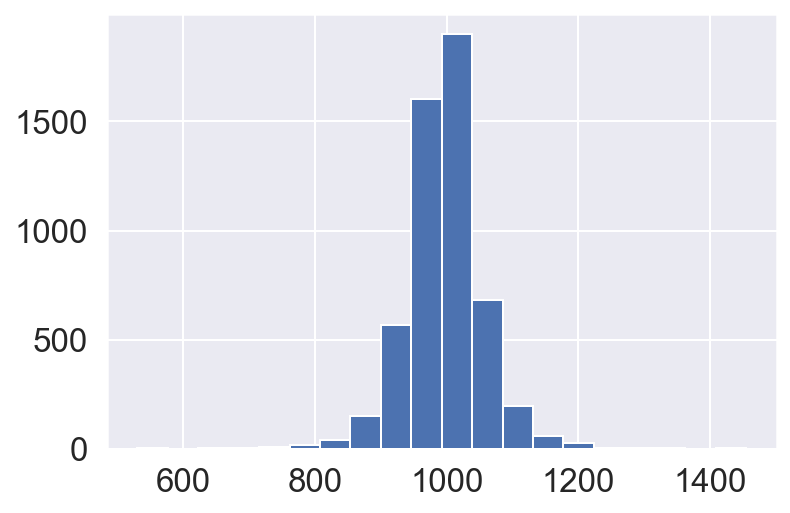

In [11]:
lengths = []
for chunk in df['chunks']:
    lengths.append(len(chunk))
plt.hist(lengths, bins=20);

Reset index and save old index as chunk number per book

In [17]:
df.reset_index(inplace=True)
df.rename(columns={"index": "book_chunk_no"}, inplace=True)

In [18]:
df.rename(columns={"index": "book_chunk_no"}, inplace=True)

### Remove some characters such as line breaks from the chunks

In [19]:
df['chunks'].head()

0    IT WAS A  short one-paragraph item in the morn...
1     I got off near the end of the line.  The map ...
2    \n There was a small coffee shop near the univ...
3    \n She and I would trade books, talk endlessly...
4    \n Once, and only once, I asked her about thes...
Name: chunks, dtype: object

In [20]:
df['chunks'] = df['chunks'].apply(lambda x: x.replace('\n', ' '))
df['chunks'] = df['chunks'].apply(lambda x: x.replace('\\', ' '))
df['chunks'] = df['chunks'].apply(lambda x: x.replace('\xa0', ''))
df['chunks'] = df['chunks'].apply(lambda x: x.replace('   ', '  '))
df['chunks'] = df['chunks'].apply(lambda x: x.replace('  ', ' '))
df['chunks'] = df['chunks'].apply(lambda x: re.sub("\'","’",x))

In [21]:
df['chunks'].head()

0    IT WAS A short one-paragraph item in the morni...
1     I got off near the end of the line. The map p...
2     There was a small coffee shop near the univer...
3     She and I would trade books, talk endlessly, ...
4     Once, and only once, I asked her about these ...
Name: chunks, dtype: object

### Create Predictor Variables with Textacy

In [22]:
en_nlp = textacy.load_spacy_lang('en_core_web_sm')

In [23]:
df['parsed'] = df['chunks'].apply(en_nlp)

In [24]:
df['n_sents'] = df['parsed'].apply(lambda x: x._.n_sents)
df['n_words'] = df['parsed'].apply(lambda x: textacy.TextStats(x).basic_counts['n_words'])
df['n_chars'] = df['parsed'].apply(lambda x: textacy.TextStats(x).basic_counts['n_chars'])
df['n_syllables'] = df['parsed'].apply(lambda x: textacy.TextStats(x).basic_counts['n_syllables'])
df['n_unique_words'] = df['parsed'].apply(lambda x: textacy.TextStats(x).basic_counts['n_unique_words'])
df['n_long_words'] = df['parsed'].apply(lambda x: textacy.TextStats(x).basic_counts['n_long_words'])
df['n_monosyllable_words'] = df['parsed'].apply(lambda x: textacy.TextStats(x).basic_counts['n_monosyllable_words'])
df['n_polysyllable_words'] = df['parsed'].apply(lambda x: textacy.TextStats(x).basic_counts['n_polysyllable_words'])

In [25]:
df.head(3)

,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words
0,0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",IT WAS A short one-paragraph item in the morni...,Alfred Birnbaum,A Wild Sheep Chase,"(IT, WAS, A, short, one, -, paragraph, item, i...",15,174,742,240,116,33,128,17
1,1,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",I got off near the end of the line. The map p...,Alfred Birnbaum,A Wild Sheep Chase,"( , I, got, off, near, the, end, of, the, line...",15,176,734,229,118,29,132,9
2,2,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",There was a small coffee shop near the univer...,Alfred Birnbaum,A Wild Sheep Chase,"( , There, was, a, small, coffee, shop, near, ...",13,195,834,250,119,29,150,9


### Tidy up Translator Column as there are some leading 'spaces'
* critical as this will be the basis of the target variable

In [26]:
df['translator'].unique()

array(['Alfred Birnbaum', 'Philip Gabriel', ' Alfred Birnbaum',
       ' Jay Rubin', 'Jay Rubin'], dtype=object)

In [27]:
df['translator'] = df['translator'].apply(lambda x: x.lstrip())

In [28]:
df['translator'].unique()

array(['Alfred Birnbaum', 'Philip Gabriel', 'Jay Rubin'], dtype=object)

### Check number of chunks per translator

In [29]:
df['translator'].value_counts()

Jay Rubin          2087
Alfred Birnbaum    1759
Philip Gabriel     1407
Name: translator, dtype: int64

### Set numeric code for translator names in case needed later

In [30]:
di = {'Alfred Birnbaum': 0, 'Jay Rubin': 1, 'Philip Gabriel':2}
df['trans_code'] = df['translator'].replace(di)

### Add a column for the length of each chunk in characters

In [31]:
df['chunk_length'] = df.chunks.map(len)

We can see that there are a few outliers with fewer than 800 or more an 1200 characters. Best to drop these as this may skew the 'count' attributes even if normalised to equivalent of 1000 characters

In [32]:
df['chunk_length'].describe()

count    5253.000000
mean      983.511898
std        58.368698
min       519.000000
25%       952.000000
50%       982.000000
75%      1014.000000
max      1415.000000
Name: chunk_length, dtype: float64

In [34]:
len(df[(df['chunk_length'] < 800) |  (df['chunk_length'] > 1200)])

40

In [35]:
df = df[(df['chunk_length'] >= 800) |  (df['chunk_length'] <= 1200)]

### Normalise the indicators to the equivalent for a 1000 char chunk
* take column value and divide by length for that chunk then multiply by 1000
* add this as a new column with name appended with _norm

In [36]:
# normalise the indicators to the length of the chunk
def var_normalize(df, column_list):
    for col in column_list:
        norm_col = col + '_norm'
        df[norm_col] = df.apply(lambda x: x[col] if x[col] == 0 else (x[col]/x['chunk_length'])*1000, axis=1)
        
ind_cols = ['n_sents', 'n_words', 'n_chars', 'n_syllables', 'n_unique_words', 
            'n_long_words', 'n_monosyllable_words', 'n_polysyllable_words']

var_normalize(df, ind_cols)

In [37]:
df.head(3)

,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm
0,0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",IT WAS A short one-paragraph item in the morni...,Alfred Birnbaum,A Wild Sheep Chase,"(IT, WAS, A, short, one, -, paragraph, item, i...",15,174,742,240,116,33,128,17,0,944,15.889831,184.322034,786.016949,254.237288,122.881356,34.957627,135.593220,18.008475
1,1,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",I got off near the end of the line. The map p...,Alfred Birnbaum,A Wild Sheep Chase,"( , I, got, off, near, the, end, of, the, line...",15,176,734,229,118,29,132,9,0,935,16.042781,188.235294,785.026738,244.919786,126.203209,31.016043,141.176471,9.625668
2,2,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",There was a small coffee shop near the univer...,Alfred Birnbaum,A Wild Sheep Chase,"( , There, was, a, small, coffee, shop, near, ...",13,195,834,250,119,29,150,9,0,1057,12.298959,184.484390,789.025544,236.518448,112.582781,27.436140,141.911069,8.514664


In [38]:
# # selecting columns starting with n_ but not ending with _norm
# df[[i for i in df.columns if (i.startswith('n_')) and (i.endswith('_norm') == False)] + ['trans_code']]

### Add some sentiment analysis attributes using Vader

In [39]:
vader = SentimentIntensityAnalyzer()

In [40]:
analyzer = SentimentIntensityAnalyzer()

In [41]:
vader_scores = df['chunks'].map(analyzer.polarity_scores)

In [42]:
vader_scores

0       {'neg': 0.075, 'neu': 0.862, 'pos': 0.064, 'co...
1       {'neg': 0.079, 'neu': 0.891, 'pos': 0.03, 'com...
2       {'neg': 0.066, 'neu': 0.84, 'pos': 0.094, 'com...
3       {'neg': 0.036, 'neu': 0.895, 'pos': 0.069, 'co...
4       {'neg': 0.064, 'neu': 0.887, 'pos': 0.049, 'co...
                              ...                        
5248    {'neg': 0.047, 'neu': 0.856, 'pos': 0.097, 'co...
5249    {'neg': 0.093, 'neu': 0.751, 'pos': 0.155, 'co...
5250    {'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...
5251    {'neg': 0.062, 'neu': 0.837, 'pos': 0.101, 'co...
5252    {'neg': 0.079, 'neu': 0.815, 'pos': 0.106, 'co...
Name: chunks, Length: 5253, dtype: object

In [43]:
dvec = DictVectorizer()

vader_scores = dvec.fit_transform(vader_scores)
vader_scores

<5253x4 sparse matrix of type '<class 'numpy.float64'>'
	with 21012 stored elements in Compressed Sparse Row format>

In [44]:
dvec.feature_names_

['compound', 'neg', 'neu', 'pos']

### Add columns containing vader scores

In [45]:
for i, col in enumerate(dvec.feature_names_):
    df['vader_{}'.format(col)] = vader_scores[:, i].toarray().ravel()

In [46]:
df.head(3)

,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos
0,0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",IT WAS A short one-paragraph item in the morni...,Alfred Birnbaum,A Wild Sheep Chase,"(IT, WAS, A, short, one, -, paragraph, item, i...",15,174,742,240,116,33,128,17,0,944,15.889831,184.322034,786.016949,254.237288,122.881356,34.957627,135.593220,18.008475,-0.4798,0.075,0.862,0.064
1,1,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",I got off near the end of the line. The map p...,Alfred Birnbaum,A Wild Sheep Chase,"( , I, got, off, near, the, end, of, the, line...",15,176,734,229,118,29,132,9,0,935,16.042781,188.235294,785.026738,244.919786,126.203209,31.016043,141.176471,9.625668,-0.7902,0.079,0.891,0.030
2,2,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",There was a small coffee shop near the univer...,Alfred Birnbaum,A Wild Sheep Chase,"( , There, was, a, small, coffee, shop, near, ...",13,195,834,250,119,29,150,9,0,1057,12.298959,184.484390,789.025544,236.518448,112.582781,27.436140,141.911069,8.514664,0.4215,0.066,0.840,0.094


### Add variables for counts of 'POS' (parts of speech)

In [47]:
for i, p in enumerate(df['parsed']):
    D = dict(Counter([token.pos_ for token in p]))
    col_list = []
    for x in D:
        col_name = str.lower(x) + '_count'
        df.loc[df.index[i], col_name] = D[x]

In [48]:
df.head(3)

,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos,pron_count,verb_count,det_count,adj_count,num_count,punct_count,noun_count,adp_count,cconj_count,sconj_count,adv_count,aux_count,part_count,propn_count,space_count,intj_count,sym_count,x_count
0,0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",IT WAS A short one-paragraph item in the morni...,Alfred Birnbaum,A Wild Sheep Chase,"(IT, WAS, A, short, one, -, paragraph, item, i...",15,174,742,240,116,33,128,17,0,944,15.889831,184.322034,786.016949,254.237288,122.881356,34.957627,135.593220,18.008475,-0.4798,0.075,0.862,0.064,18.0,20.0,31.0,9.0,2.0,33.0,51.0,19.0,6.0,3.0,5.0,5.0,3.0,2.0,NaN,NaN,NaN,NaN
1,1,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",I got off near the end of the line. The map p...,Alfred Birnbaum,A Wild Sheep Chase,"( , I, got, off, near, the, end, of, the, line...",15,176,734,229,118,29,132,9,0,935,16.042781,188.235294,785.026738,244.919786,126.203209,31.016043,141.176471,9.625668,-0.7902,0.079,0.891,0.030,17.0,22.0,25.0,13.0,5.0,29.0,42.0,22.0,5.0,2.0,12.0,12.0,NaN,NaN,1.0,NaN,NaN,NaN
2,2,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",There was a small coffee shop near the univer...,Alfred Birnbaum,A Wild Sheep Chase,"( , There, was, a, small, coffee, shop, near, ...",13,195,834,250,119,29,150,9,0,1057,12.298959,184.484390,789.025544,236.518448,112.582781,27.436140,141.911069,8.514664,0.4215,0.066,0.840,0.094,18.0,26.0,28.0,14.0,1.0,35.0,38.0,19.0,6.0,6.0,11.0,11.0,4.0,13.0,1.0,NaN,NaN,NaN


### Normalise the POS count indicators to the equivalent for a 1000 char chunk
* take column value and divide by length for that chunk then multiply by 1000
* add this as a new column with name appended with _norm

In [49]:
# # selecting columns starting with n_ but not ending with _norm
pos_count_cols = [i for i in df.columns if i.endswith('_count')]

In [50]:
df[pos_count_cols] = df[pos_count_cols].fillna(0)

In [51]:
# normalise the indicators to the length of the chunk
def var_normalize(df, column_list):
    for col in column_list:
        norm_col = col + '_norm'
        df[norm_col] = df.apply(lambda x: x[col] if x[col] == 0 else (x[col]/x['chunk_length'])*1000, axis=1)
        
ind_cols = ['n_sents', 'n_words', 'n_chars', 'n_syllables', 'n_unique_words', 
            'n_long_words', 'n_monosyllable_words', 'n_polysyllable_words']

var_normalize(df, pos_count_cols)

In [52]:
df.head()

,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos,pron_count,verb_count,det_count,adj_count,num_count,punct_count,noun_count,adp_count,cconj_count,sconj_count,adv_count,aux_count,part_count,propn_count,space_count,intj_count,sym_count,x_count,pron_count_norm,verb_count_norm,det_count_norm,adj_count_norm,num_count_norm,punct_count_norm,noun_count_norm,adp_count_norm,cconj_count_norm,sconj_count_norm,adv_count_norm,aux_count_norm,part_count_norm,propn_count_norm,space_count_norm,intj_count_norm,sym_count_norm,x_count_norm
0,0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",IT WAS A short one-paragraph item in the morni...,Alfred Birnbaum,A Wild Sheep Chase,"(IT, WAS, A, short, one, -, paragraph, item, i...",15,174,742,240,116,33,128,17,0,944,15.889831,184.322034,786.016949,254.237288,122.881356,34.957627,135.593220,18.008475,-0.4798,0.075,0.862,0.064,18.0,20.0,31.0,9.0,2.0,33.0,51.0,19.0,6.0,3.0,5.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,19.067797,21.186441,32.838983,9.533898,2.118644,34.957627,54.025424,20.127119,6.355932,3.177966,5.296610,5.296610,3.177966,2.118644,0.000000,0.000000,0.0,0.0
1,1,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",I got off near the end of the line. The map p...,Alfred Birnbaum,A Wild Sheep Chase,"( , I, got, off, near, the, end, of, the, line...",15,176,734,229,118,29,132,9,0,935,16.042781,188.235294,785.026738,244.919786,126.203209,31.016043,141.176471,9.625668,-0.7902,0.079,0.891,0.030,17.0,22.0,25.0,13.0,5.0,29.0,42.0,22.0,5.0,2.0,12.0,12.0,0.0,0.0,1.0,0.0,0.0,0.0,18.181818,23.529412,26.737968,13.903743,5.347594,31.016043,44.919786,23.529412,5.347594,2.139037,12.834225,12.834225,0.000000,0.000000,1.069519,0.000000,0.0,0.0
2,2,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",There was a small coffee shop near the univer...,Alfred Birnbaum,A Wild Sheep Chase,"( , There, was, a, small, coffee, shop, near, ...",13,195,834,250,119,29,150,9,0,1057,12.298959,184.484390,789.025544,236.518448,112.582781,27.436140,141.911069,8.514664,0.4215,0.066,0.840,0.094,18.0,26.0,28.0,14.0,1.0,35.0,38.0,19.0,6.0,6.0,11.0,11.0,4.0,13.0,1.0,0.0,0.0,0.0,17.029328,24.597919,26.490066,13.245033,0.946074,33.112583,35.950804,17.975402,5.676443,5.676443,10.406812,10.406812,3.784295,12.298959,0.946074,0.000000,0.0,0.0
3,3,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...","She and I would trade books, talk endlessly, ...",Alfred Birnbaum,A Wild Sheep Chase,"( , She, and, I, would, trade, books, ,, talk,...",14,179,754,230,109,25,143,11,0,963,14.537902,185.877466,782.969886,238.836968,113.187954,25.960540,148.494289,11.422638,0.7184,0.036,0.895,0.069,26.0,38.0,24.0,6.0,0.0,37.0,31.0,19.0,4.0,2.0,17.0,8.0,4.0,1.0,1.0,0.0,0.0,0.0,26.998962,39.460021,24.922118,6.230530,0.000000,38.421599,32.191070,19.730010,4.153686,2.076843,17.653167,8.307373,4.153686,1.038422,1.038422,0.000000,0.0,0.0
4,4,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...","Once, and only once, I asked her about these ...",Alfred Birnbaum,A Wild Sheep Chase,"( ,

In [67]:
out_path = '../../../../Documents/murakami/pkl3/'
out_name = 'df_all_v01'
out_full_path = out_path + out_name + '.pkl'

In [68]:
# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(df, fp)


# read back pickle
with open (out_full_path, 'rb') as fp:
    df_read = pickle.load(fp)

In [69]:
df_read.head()

,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos,pron_count,verb_count,det_count,adj_count,num_count,punct_count,noun_count,adp_count,cconj_count,sconj_count,adv_count,aux_count,part_count,propn_count,space_count,intj_count,sym_count,x_count,pron_count_norm,verb_count_norm,det_count_norm,adj_count_norm,num_count_norm,punct_count_norm,noun_count_norm,adp_count_norm,cconj_count_norm,sconj_count_norm,adv_count_norm,aux_count_norm,part_count_norm,propn_count_norm,space_count_norm,intj_count_norm,sym_count_norm,x_count_norm
0,0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",IT WAS A short one-paragraph item in the morni...,Alfred Birnbaum,A Wild Sheep Chase,"(IT, WAS, A, short, one, -, paragraph, item, i...",15,174,742,240,116,33,128,17,0,944,15.889831,184.322034,786.016949,254.237288,122.881356,34.957627,135.593220,18.008475,-0.4798,0.075,0.862,0.064,18.0,20.0,31.0,9.0,2.0,33.0,51.0,19.0,6.0,3.0,5.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,19.067797,21.186441,32.838983,9.533898,2.118644,34.957627,54.025424,20.127119,6.355932,3.177966,5.296610,5.296610,3.177966,2.118644,0.000000,0.000000,0.0,0.0
1,1,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",I got off near the end of the line. The map p...,Alfred Birnbaum,A Wild Sheep Chase,"( , I, got, off, near, the, end, of, the, line...",15,176,734,229,118,29,132,9,0,935,16.042781,188.235294,785.026738,244.919786,126.203209,31.016043,141.176471,9.625668,-0.7902,0.079,0.891,0.030,17.0,22.0,25.0,13.0,5.0,29.0,42.0,22.0,5.0,2.0,12.0,12.0,0.0,0.0,1.0,0.0,0.0,0.0,18.181818,23.529412,26.737968,13.903743,5.347594,31.016043,44.919786,23.529412,5.347594,2.139037,12.834225,12.834225,0.000000,0.000000,1.069519,0.000000,0.0,0.0
2,2,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",There was a small coffee shop near the univer...,Alfred Birnbaum,A Wild Sheep Chase,"( , There, was, a, small, coffee, shop, near, ...",13,195,834,250,119,29,150,9,0,1057,12.298959,184.484390,789.025544,236.518448,112.582781,27.436140,141.911069,8.514664,0.4215,0.066,0.840,0.094,18.0,26.0,28.0,14.0,1.0,35.0,38.0,19.0,6.0,6.0,11.0,11.0,4.0,13.0,1.0,0.0,0.0,0.0,17.029328,24.597919,26.490066,13.245033,0.946074,33.112583,35.950804,17.975402,5.676443,5.676443,10.406812,10.406812,3.784295,12.298959,0.946074,0.000000,0.0,0.0
3,3,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...","She and I would trade books, talk endlessly, ...",Alfred Birnbaum,A Wild Sheep Chase,"( , She, and, I, would, trade, books, ,, talk,...",14,179,754,230,109,25,143,11,0,963,14.537902,185.877466,782.969886,238.836968,113.187954,25.960540,148.494289,11.422638,0.7184,0.036,0.895,0.069,26.0,38.0,24.0,6.0,0.0,37.0,31.0,19.0,4.0,2.0,17.0,8.0,4.0,1.0,1.0,0.0,0.0,0.0,26.998962,39.460021,24.922118,6.230530,0.000000,38.421599,32.191070,19.730010,4.153686,2.076843,17.653167,8.307373,4.153686,1.038422,1.038422,0.000000,0.0,0.0
4,4,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...","Once, and only once, I asked her about these ...",Alfred Birnbaum,A Wild Sheep Chase,"( ,

### Check some chunks to see how the text looks

In [56]:
df[df.book_title == 'The Wind Up Bird Chronicle'].chunks.iloc[1]

' The spaghetti pot was steaming nicely, and Claudio Abbado was still conducting The Thieving Magpie . “Sorry, but you caught me in the middle of cooking spaghetti. Could you call back later?” “Spaghetti!? What are you doing cooking spaghetti at 10.30 in the morning?” “That’s none of your business,” I said. “ I decide what I eat and when I eat it.” “Fair enough. I’ll call back,” she said, her voice now flat and expressionless. A slight change in mood can do amazing things to the tone of a person’s voice. “Hold on a minute,” I said before she could hang up. “If this is some new sales gimmick, you can forget it. I’m out of work. I’m not in the market for anything.” “Don’t worry. I know.” “You know? You know what?” “That you’re out of work. I know about that. So, go and cook your precious spaghetti.” “Who the hell –” She rang off. Deprived of outlet for my feelings, I stared at the phone in my hand until I remembered the spaghetti.'

In [57]:
df[df.book_title == 'The Wind Up Bird Chronicle'].parsed.iloc[1]

 The spaghetti pot was steaming nicely, and Claudio Abbado was still conducting The Thieving Magpie . “Sorry, but you caught me in the middle of cooking spaghetti. Could you call back later?” “Spaghetti!? What are you doing cooking spaghetti at 10.30 in the morning?” “That’s none of your business,” I said. “ I decide what I eat and when I eat it.” “Fair enough. I’ll call back,” she said, her voice now flat and expressionless. A slight change in mood can do amazing things to the tone of a person’s voice. “Hold on a minute,” I said before she could hang up. “If this is some new sales gimmick, you can forget it. I’m out of work. I’m not in the market for anything.” “Don’t worry. I know.” “You know? You know what?” “That you’re out of work. I know about that. So, go and cook your precious spaghetti.” “Who the hell –” She rang off. Deprived of outlet for my feelings, I stared at the phone in my hand until I remembered the spaghetti.

In [58]:
df[df.book_title == 'A Wild Sheep Chase'].chunks.iloc[1]

' I got off near the end of the line. The map proved about as helpful as a globe would have been. I ended up buying pack after pack of cigarettes, asking directions each time. It was a wood-frame house with a brown board fence around it. A small yard, with an abandoned ceramic brazier filled with standing rainwater. The ground was dark and damp. She’d left home when she was sixteen. Which may have been the reason why the funeral was so somber. Only family present, nearly everyone older. It was presided over by her older brother, barely thirty, or maybe it was her brother-in-law. Her father, a shortish man in his mid-fifties, wore a black armband of mourning. He stood by the entrance and scarcely moved. Reminded me of a street washed clean after a downpour. On leaving, I lowered my head in silence, and he lowered his head in return, without a word. I met her in autumn nine years ago, when I was twenty and she was seventeen.'

In [59]:
df[df.book_title == 'A Wild Sheep Chase'].parsed.iloc[1]

 I got off near the end of the line. The map proved about as helpful as a globe would have been. I ended up buying pack after pack of cigarettes, asking directions each time. It was a wood-frame house with a brown board fence around it. A small yard, with an abandoned ceramic brazier filled with standing rainwater. The ground was dark and damp. She’d left home when she was sixteen. Which may have been the reason why the funeral was so somber. Only family present, nearly everyone older. It was presided over by her older brother, barely thirty, or maybe it was her brother-in-law. Her father, a shortish man in his mid-fifties, wore a black armband of mourning. He stood by the entrance and scarcely moved. Reminded me of a street washed clean after a downpour. On leaving, I lowered my head in silence, and he lowered his head in return, without a word. I met her in autumn nine years ago, when I was twenty and she was seventeen.

In [60]:
df[(df.book_title == 'Norwegian Wood') & (df.translator == 'Alfred Birnbaum')].chunks.iloc[1]

'"Which do you think?" "I have absolutely no idea. Whichever, he hardly seems too together." "He’s a doctor. Dr. Miyata," said Naoko. "He’s got to be the biggest nut around here. I’d wager on it," said Reiko. "Him and Mr. Omura, the gatekeeper, who’s pretty far out, too," said Naoko. "Yeah, he’s crazy all right," said Reiko, nodding as she jabbed a fork into her broccoli. "The guy shouts who knows what while he does those im\xadpossible exercises every morning. Then, before Naoko’s time, there was this girl named Kinoshita in accounting who tried to commit suicide, not to mention Nurse Tokushima who became a real bad alcoholic and had to quit last year." "Sounds like the staff and the patients ought to change places," I said with some concern. · "You said it," said Reiko, waving her fork. "I see you’re getting to know the ropes around here." "So it would seem," I agreed. "The together thing about us," said Reiko, "is that we know we’re not together.'

In [61]:
df[(df.book_title == 'Norwegian Wood') & (df.translator == 'Alfred Birnbaum')].parsed.iloc[1]

"Which do you think?" "I have absolutely no idea. Whichever, he hardly seems too together." "He’s a doctor. Dr. Miyata," said Naoko. "He’s got to be the biggest nut around here. I’d wager on it," said Reiko. "Him and Mr. Omura, the gatekeeper, who’s pretty far out, too," said Naoko. "Yeah, he’s crazy all right," said Reiko, nodding as she jabbed a fork into her broccoli. "The guy shouts who knows what while he does those im­possible exercises every morning. Then, before Naoko’s time, there was this girl named Kinoshita in accounting who tried to commit suicide, not to mention Nurse Tokushima who became a real bad alcoholic and had to quit last year." "Sounds like the staff and the patients ought to change places," I said with some concern. · "You said it," said Reiko, waving her fork. "I see you’re getting to know the ropes around here." "So it would seem," I agreed. "The together thing about us," said Reiko, "is that we know we’re not together.

In [62]:
df[(df.book_title == 'Norwegian Wood') & (df.translator == 'Jay Rubin')].chunks.iloc[1]

'I straightened up and looked out of the window at the dark clouds hanging over the North Sea, thinking of all I had lost in the course of my life: times gone for ever, friends who had died or disappeared, feelings I would never know again. The plane reached the gate. People began unfastening their seatbelts and pulling luggage from the overhead lockers, and all the while I was in the meadow. I could smell the grass, feel the wind on my face, hear the cries of the birds. Autumn 1969, and soon I would be 20. The stewardess came to check on me again. This time she sat next to me and asked if I was all right. "I’m fine, thanks," I said with a smile. "Just feeling kind of blue." "I know what you mean," she said. "It happens to me, too, every once in a while." She stood and gave me a lovely smile. "Well, then, have a nice trip. Auf Wiedersehen." "Auf Wiedersehen." Eighteen years have gone by, and still I can bring back every detail of that day in the meadow. Washed clean of summer’s dust by

In [63]:
df[(df.book_title == 'Norwegian Wood') & (df.translator == 'Jay Rubin')].parsed.iloc[1]

I straightened up and looked out of the window at the dark clouds hanging over the North Sea, thinking of all I had lost in the course of my life: times gone for ever, friends who had died or disappeared, feelings I would never know again. The plane reached the gate. People began unfastening their seatbelts and pulling luggage from the overhead lockers, and all the while I was in the meadow. I could smell the grass, feel the wind on my face, hear the cries of the birds. Autumn 1969, and soon I would be 20. The stewardess came to check on me again. This time she sat next to me and asked if I was all right. "I’m fine, thanks," I said with a smile. "Just feeling kind of blue." "I know what you mean," she said. "It happens to me, too, every once in a while." She stood and gave me a lovely smile. "Well, then, have a nice trip. Auf Wiedersehen." "Auf Wiedersehen." Eighteen years have gone by, and still I can bring back every detail of that day in the meadow. Washed clean of summer’s dust by 

In [64]:
df[df.book_title == 'The Elephant Vanishes'].chunks.iloc[1]

'And I pride myself on a near-perfect ear for voices, so I’m sure there’s no mistake. This is the voice of a woman I don’t know. A soft, low, nondescript voice. “Pardon me, but what number might you have been calling?” I put on my most polite language. “What difference does that make? All I want is ten minutes of your time. Ten minutes to come to an understanding.” She cinches the matter quick and neat. “Come to an understanding?” “Of our feelings,” says the woman succinctly. I crane my neck back through the door I’ve left open to peer into the kitchen. A plume of white steam rising cheerfully from the spaghetti pot, and Abbado is still conducting hisGazza. “If you don’t mind, I’ve got spaghetti on right now. It’s almost done, and it’ll be ruined if I talk with you for ten minutes. So I’m going to hang up, all right?” “Spaghetti?” the woman sputters in disbelief. “It’s only ten-thirty in the morning. What are you doing cooking spaghetti at ten-thirty in the morning? Kind of strange, do

In [65]:
df[df.book_title == 'The Elephant Vanishes'].parsed.iloc[1]

And I pride myself on a near-perfect ear for voices, so I’m sure there’s no mistake. This is the voice of a woman I don’t know. A soft, low, nondescript voice. “Pardon me, but what number might you have been calling?” I put on my most polite language. “What difference does that make? All I want is ten minutes of your time. Ten minutes to come to an understanding.” She cinches the matter quick and neat. “Come to an understanding?” “Of our feelings,” says the woman succinctly. I crane my neck back through the door I’ve left open to peer into the kitchen. A plume of white steam rising cheerfully from the spaghetti pot, and Abbado is still conducting hisGazza. “If you don’t mind, I’ve got spaghetti on right now. It’s almost done, and it’ll be ruined if I talk with you for ten minutes. So I’m going to hang up, all right?” “Spaghetti?” the woman sputters in disbelief. “It’s only ten-thirty in the morning. What are you doing cooking spaghetti at ten-thirty in the morning? Kind of strange, don

In [66]:
df.sort_values('vader_pos', ascending=False)['parsed'].iloc[0]

 Just as he appreciated Sara’s appearance, he also enjoyed the way she dressed. Her clothes were always simple and subdued, but they were lovely and fit her perfectly. Tsukuru could easily imagine, though, that what appeared to be simple outfits had taken much time to choose, and also hadn’t come cheap. Her accessories and makeup, too, were low-key yet refined. Tsukuru himself wasn’t particular about clothes, but he’d always loved seeing a well-dressed woman. Just like he enjoyed listening to beautiful music. His two older sisters loved clothes, and when they were young, before they went out on a date, they had grabbed Tsukuru first to get his opinion of their outfit. He wasn’t sure why, but they were very serious about it. What do you think? they’d ask. Do these go well together? And he would give his honest opinion, from a male perspective. His sisters respected his opinion, which made him happy, and before long, this became a habit.